# Should I use free-air correction?

Import packages

In [121]:
import numpy as np
import boule as bl
import verde as vd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Normal gravity

Gravity disturbance is defined as the difference between the norm of the observed gravity vector and the norm of the normal gravity vector on the same observation point $\mathbf{p}$ (Bathelmes, 2013):

$$ \delta g(\mathbf{p}) = |\bar{g}_\text{obs}(\mathbf{p})| - |\bar{\gamma}(\mathbf{p})| = {g}_\text{obs}(\mathbf{p}) - \gamma(\mathbf{p}) $$

In order to compute the magntide of the normal gravity vector we should start by defining what do we understand as _normal Earth_.
This problem has been historically addressed by assuming that the _normal gravity field_ of the Earth is the one generated by a ellipsoid of revolution that better approximates to the true figure of the Earth (Heiskanen and Moritz, 1967). Read Pasteka for a discussion about the definition of _normal Earth_.
By taking this definition of _normal Earth_, we can use the famous Somigliana (1929) equation to compute the magnitude of the normal gravity vector on any observation point located on the surface of the ellipsoid:

$$ \gamma_0(\varphi) = \frac{a \gamma_a \cos^2 \varphi + b \gamma_b \sin^2 \varphi}{\sqrt{a \cos^2 \varphi + b \sin^2 \varphi}} $$

where $\varphi$ is the ellipsoidal latitude of the observation point $\mathbf{p}$; $a$ and $b$ are the semi-major and the semi-minor axes of the ellipsoid of revolution, respectively; and $\gamma_a$ and $\gamma_b$ are the magnitude of the normal gravity vector on the equator and the poles, respectively.
The latter two quantities can be easily computed from the parameters of the ellipsoid along (Heiskanen and Moritz, 1967, p.69).

Lets define a function to evaluate Somigliana equation on any latitude for any given ellipsoid from [Boule](https://www.fatiando.org/boule):

In [19]:
def normal_gravity_surface(latitude, ellipsoid):
    """
    Computes normal gravity on the surface of the ellipsoid [mGal]

    Uses the closed-form Somigliana equation [Hofmann-WellenhofMoritz2006]_.
    
    Parameters
    ----------
    latitude: float or array
        Latitude of the observation point where normal gravity will be
        computed. Latitudes must be in degrees.
    ellipsoid : :class:`boule.Ellipsoid`
        Reference ellipsoid used to compute the normal gravity. Must be
        an `Ellipsoid` class of Boule.
        
    Returns
    -------
    gamma_0 : float or array
        Normal gravity on the surface of the ellipsoid in mGal.
    """
    latitude_radians = np.radians(latitude)
    coslat = np.cos(latitude_radians)
    sinlat = np.sin(latitude_radians)
    gravity = (
        ellipsoid.semimajor_axis * ellipsoid.gravity_equator * coslat ** 2
        + ellipsoid.semiminor_axis * ellipsoid.gravity_pole * sinlat ** 2
    ) / np.sqrt(
        ellipsoid.semimajor_axis ** 2 * coslat ** 2
        + ellipsoid.semiminor_axis ** 2 * sinlat ** 2
    )
    # Convert to mGal
    return 1e5 * gravity

Get the WGS84 ellipsoid from Boule

In [10]:
ellipsoid = bl.WGS84
print(ellipsoid)

Ellipsoid(name='WGS84', semimajor_axis=6378137, flattening=0.0033528106647474805, geocentric_grav_const=398600441800000.0, angular_velocity=7.292115e-05, long_name='World Geodetic System 1984', reference='Hofmann-Wellenhof, B., & Moritz, H. (2006). Physical Geodesy (2nd, corr. ed. 2006 edition ed.). Wien\u202f; New York: Springer.')


Plot Somigliana equation for different latitudes

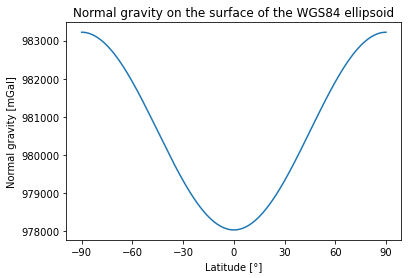

In [17]:
latitudes = np.linspace(-90, 90, 181)

plt.plot(latitudes, normal_gravity_surface(latitudes, ellipsoid))
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel("Latitude [°]")
plt.ylabel("Normal gravity [mGal]")
plt.title("Normal gravity on the surface of the WGS84 ellipsoid")
plt.show()

## Free-air correction

Somigliana (1929) equation can be used to compute the gravity disturbance **only** if the observations have been carried out **on the ellipsoid surface**, but most surveys meassure gravity acceleration at different heights above the ellipsoid:
- ground surveys follow the topography,
- satellite observations are carried out at a few hundred kilometers above Earth's surface,
- shipborne surveys are carried out at sea level (on the geoid),
- airborne surveyes are carried out at several meters above the surface.

Therefore we need a way to compute the magnitude of the normal gravity vector that takes into account the height of the observation point $\mathbf{p}$ above the ellipsoid.

A method that was widely applied through the last century is the well-known **free-air correction**.
It consists in a first-order approximation of the magnitude of the normal gravity vector $\gamma(\mathbf{p})$.
The normal gravity can be expaneded through a Talor series:

$$ \gamma(\mathbf{p}) = \gamma_0(\varphi) + \frac{\partial \gamma}{\partial h} h + \frac{1}{2} \frac{\partial^2 \gamma}{\partial h^2} h^2 + \dots, $$

where $h$ is the ellipsoidal height of the observation point $\mathbf{p}$. Thus it can be approximated by:

$$ \gamma(\mathbf{p}) \simeq \gamma_0(\varphi) + \frac{\partial \gamma}{\partial h} h $$

The second term is usually defined as the **free-air correction term** (Blakely, 1984), which leads to the famous 0.3086 factor:

$$ \gamma_\text{fa}(h) = \frac{\partial \gamma}{\partial h} h = -0.3086 \frac{\text{mGal}}{\text{m}} h $$

Worth noting that this first-order approximation is only valid for observation heights much smaller than the semi-major axis of the ellipsoid.


Let's define a function that computes the normal gravity on any latitude and height as a first order approximation:

In [26]:
def normal_gravity_first_order(latitude, height, ellipsoid):
    """
    First-order approximation of the normal gravity on any external point [mGal]

    Uses the closed-form Somigliana equation [Hofmann-WellenhofMoritz2006]_ and 
    the free-air correction term.
    
    Parameters
    ----------
    latitude: float or array
        Latitude of the observation point where normal gravity will be
        computed. Latitudes must be in degrees.
    height : float or array
        Height of obervation points in meters.
    ellipsoid : :class:`boule.Ellipsoid`
        Reference ellipsoid used to compute the normal gravity. Must be
        an `Ellipsoid` class of Boule.
        
    Returns
    -------
    gamma : float or array
        First order approximation of the normal gravity in mGal.
    """
    free_air = - 0.3086 * height
    return normal_gravity_surface(latitude, ellipsoid) + free_air

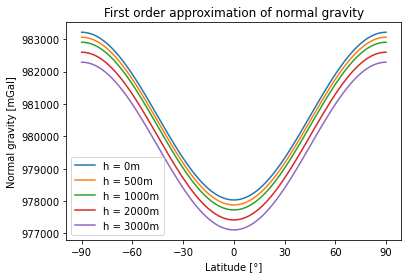

In [54]:
latitudes = np.linspace(-90, 90, 181)
heights = [0, 500, 1e3, 2e3, 3e3]

for height in heights:
    plt.plot(
        latitudes,
        normal_gravity_first_order(latitudes, height, ellipsoid),
        label="h = {:.0f}m".format(height),
    )
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel("Latitude [°]")
plt.ylabel("Normal gravity [mGal]")
plt.title("First order approximation of normal gravity")
plt.legend()
plt.show()

<ipython-input-52-5b988b9757db>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(latitudes, heights, normal_gravity_first_order(latitudes, heights, ellipsoid))


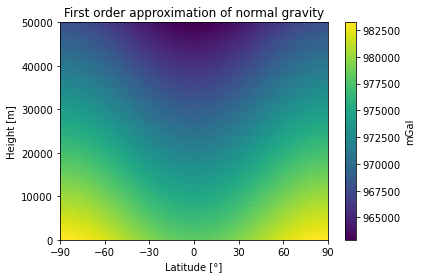

In [52]:
latitudes = np.linspace(-90, 90, 181)
heights = np.arange(0, 51e3, 1e3)

latitudes, heights = np.meshgrid(latitudes, heights)
plt.pcolormesh(latitudes, heights, normal_gravity_first_order(latitudes, heights, ellipsoid))
plt.colorbar(label="mGal")
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel("Latitude [°]")
plt.ylabel("Height [m]")
plt.title("First order approximation of normal gravity")
plt.show()

Second order approximations have also been used (see Heiskanen and Moritz, 1967, p.80).

## Closed-form formula for normal gravity

Applying Somigliana equation and the free-air correction to compute the normal gravity at any observation point might be tempting due to its simplicity, although it involves some approximations and they have introduce some misconceptions about what the free-air correction means. As Blakely (1984) states, _the free air correction is sometimes referred to as moving the observation point to sea level, but this description is misleading._

These two issues can be solved by computing the **analytical expression** of the normal gravity, without applying any approximations. The **closed-form formula** of the magntiude of the normal gravity vector is given by Li and Götze (2001). This formula involves more complex computations in comparison with the Somigliana equation, but we can easily use it through the :meth:`boule.Ellipsoid.normal_gravity` method.

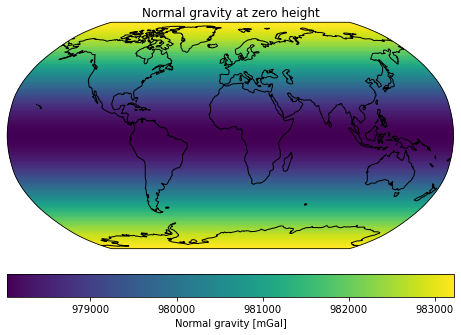

In [132]:
height = 0
longitude, latitude = vd.grid_coordinates((0, 360, -90, 90), spacing=1)
gamma = ellipsoid.normal_gravity(latitude, height)

plt.figure(figsize=(8, 9.5))
ax = plt.axes(projection=ccrs.Robinson())
tmp = ax.pcolormesh(longitude, latitude, gamma, transform=ccrs.PlateCarree())
ax.coastlines(resolution='110m')
plt.colorbar(tmp, orientation="horizontal", pad=0.05, label="Normal gravity [mGal]")
plt.title("Normal gravity at zero height")
plt.show()

## Comparison

How good is the first-order approximation? Let's compare the Somigliana equation + free-air correction with the closed-form formula for the normal gravity.

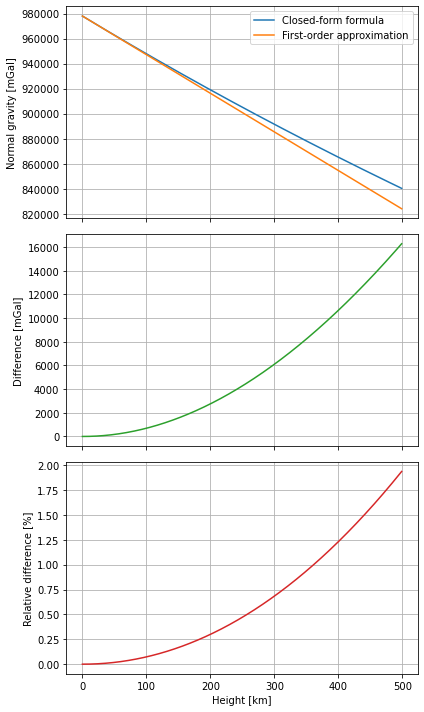

In [116]:
latitude = 0
heights = np.arange(0, 500e3, 1e3)

normal_gravity = ellipsoid.normal_gravity(latitude, heights)
normal_gravity_approx = normal_gravity_first_order(latitude, heights, ellipsoid)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 10))
ax1.plot(heights* 1e-3, normal_gravity, label="Closed-form formula")
ax1.plot(heights * 1e-3, normal_gravity_approx, label="First-order approximation")
ax1.set_ylabel("Normal gravity [mGal]")
ax1.legend()

difference = normal_gravity - normal_gravity_approx
ax2.plot(heights * 1e-3, difference, c="C2")
ax2.set_ylabel("Difference [mGal]")

relative_difference = difference / normal_gravity * 100
ax3.plot(heights * 1e-3, relative_difference, c="C3")
ax3.set_xlabel("Height [km]")
ax3.set_ylabel("Relative difference [%]")

for ax in (ax1, ax2, ax3):
    ax.grid()

plt.tight_layout()
plt.show()

As we can see, for observations near to the surface (ground, shipborne and airborne surveys), using the first-order approximation is accurate enough. Although when working with satelite heights (around 200km), the error of the first-order approximation starts growing significantly, introducing a errors of 2% at 500km.

## Conclusions

- The first-order approximation of the normal gravity is sufficiently accurate for observation points near to the Earth's surface.
- The closed-form formula can be used in the general case, without worrying about introducing uncertainties into the data processing step.
- The closed-form formula is mathematically more complex to compute, but Boule can do it without any problem.


## References

- Heiskanen and Moritz (1967)
- Bathelmes (2013)
- Somigliana (1929)
- Pasteka
- Blakely (1984)